## Detecting Adverse Drug Reactions Using LLMs

## Process the Data:

#### NOTE: When label is equal to 1, the reaction is severe. When it is 0, the reaction is not severe.

You only need to run the following cell one time!

In [1]:
!pip install --user shap torch datasets transformers evaluate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
# Import packages:

import os
import pandas as pd
import numpy as np

In [2]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files={"train": "train_DrugExp.csv",
                                          "test": "test_DrugExp.csv",
                                          "kaggle": "val_DrugExp.csv"})

## BERT Model

#### Hardware Setup

In [3]:
! hostname

jupyter-rm6uz


In [4]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# !pip install transformers

In [6]:
import torch
torch.cuda.empty_cache()
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [7]:
dataset['train'][0]

{'text': 'crohns, severe in duodenum feet and ankles hurt so bad no matter laying or standing tired all the time chest feels like pressure depressed hands wrists and fingers ache foggy was on remicaid and had a bad reaction could not move for a month crohns is getting better but is the tradeoff even worth it nan',
 'label': 1}

#### Import the Tokenizer & Tokenize

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

#### Import the Pre-trained Model

In [11]:
from transformers import AutoModelForSequenceClassification

# The cased model is case-sensitive: english is not the same as English
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Setup the Evaluator

In [15]:
import evaluate
from scipy.special import softmax

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### Define the Training Arguments

Full docs to TrainingArguments: https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.TrainingArguments.learning_rate

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                                 output_dir="test_trainer",
    save_strategy="no",
                                 evaluation_strategy="epoch",
                                 per_device_train_batch_size = 8, # Increase it to speed up the training. But may ROM CUDA.
                                 per_device_eval_batch_size = 8,
                                 learning_rate = 5e-5,
                                 gradient_accumulation_steps = 8, # Backprop happens once for each 8 batches.
                                 report_to="none")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
#     save_strategy="no" # Don't save the checkpoints
)

#### Train

In [19]:
%%time
trainer.train() # Will automatically use multiple GPUs if available.

CPU times: user 30min 40s, sys: 3.08 s, total: 30min 43s
Wall time: 30min 53s


TrainOutput(global_step=306, training_loss=0.23710966421887766, metrics={'train_runtime': 1852.2328, 'train_samples_per_second': 10.576, 'train_steps_per_second': 0.165, 'total_flos': 5120141137305600.0, 'train_loss': 0.23710966421887766, 'epoch': 2.9791921664626684})

In [20]:
import shutil
shutil.rmtree('test_trainer')

**A few notes:**
    
* Instantaneous batch size per device: the number of samples in each batch
* Gradient accumulation steps: Gradient accumulation means running a configured number of steps without updating the model variables while accumulating the gradients of those steps and then using the accumulated gradients to compute the variable updates. Using this method allows us to use larger batch sizes. It does not necessarily result in better performance, but it helps with training the models faster or on smaller devices. Read more about this in https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa.
* World_size is the number of GPU/TPUs
* The total train batch size is defined as train_batch_size * gradient_accumulation_steps * world_size, so in our case 8 * 8 * 4 = 256.

#### Save

In [ ]:
YourTeamFolder = "team1" # Please replace this with your team folder's name (e.g., team1)

os.chdir('/home/jovyan/Data Analytics III/'+YourTeamFolder)

trainer.save_model("base_model") 

#### Load the Model

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

loaded_model = AutoModelForSequenceClassification.from_pretrained("base_model",
                                                                  local_files_only=True)
loaded_trainer = Trainer(loaded_model)

#### Predict on Kaggle Data

In [21]:
pred_logits = loaded_trainer.predict(tokenized_dataset['kaggle'])

In [22]:
pred_logits

PredictionOutput(predictions=array([[-2.7332363 ,  3.401653  ],
       [-0.95324445,  1.253076  ],
       [ 0.23162526,  0.01520039],
       ...,
       [-1.0587548 ,  1.2875338 ],
       [ 3.4188309 , -3.9045954 ],
       [ 2.252135  , -2.9377227 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 2.3892452716827393, 'test_accuracy': 0.5573529411764706, 'test_runtime': 37.8868, 'test_samples_per_second': 35.896, 'test_steps_per_second': 4.487})

In [23]:
np.argmax(pred_logits[0], axis=-1)

array([1, 1, 0, ..., 1, 0, 0])

In [24]:
kaggle = pd.read_csv("val_DrugExp.csv")
kaggle['label'] = np.argmax(pred_logits[0], axis=-1)
kaggle['text'] = kaggle.text
kaggle[['text','label']].to_csv("to_kaggle.csv", index = False)

Submit your kaggle csv file through the link on Canvas.

#### Push to HF

In [15]:
from huggingface_hub import login, create_repo
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

my_token = "hf_ .... " # Put your HF token here.

login(my_token)
# create_repo(repo_id="paragon-analytics/ADRv2024") # Run this only for the first time you are pushing your model

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer.push_to_hub(repo_id = "paragon-analytics/ADRv2024",
                      use_temp_dir=True)
team_folder = "team1" # Please change!
model_path = '/project/mousavi_lab/msba24/'+team_folder+'/base_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.push_to_hub(repo_id = "paragon-analytics/ADRv2024",
                      use_temp_dir=True)

## To Use the Model in Future:

Now you can restart your kernel and try the following:

In [3]:
import torch
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("paragon-analytics/ADRv2024")
model = AutoModelForSequenceClassification.from_pretrained("paragon-analytics/ADRv2024")

def adr_predict(x):
    encoded_input = tokenizer(x, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = tf.nn.softmax(scores)
    return scores.numpy()[1]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [4]:
sentence = "I have severe pain."

adr_predict(sentence)

2025-04-14 23:04:27.203664: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


0.99369335

In [5]:
sentence = "I have minor pain."

adr_predict(sentence)

0.0111666545

In [6]:
# model.parameters

## Explainable NLP

#### SHAP

In [7]:
import pandas as pd
kaggle = pd.read_csv("val_DrugExp.csv")
kaggle.iloc[0].text

"Osteopenia Took the pill, 12 hours later my muscles started to really hurt, then my ribs started to burn so bad I couldn't breath, had severe muscle spasms almost like convulsions my body was so twisted with the spasms, chills that no amount of blankets could warm, every bone, every muscle hurt, I couldn't walk I needed help getting to the bathroom, I ended up going to the hospital, after telling them what I took, they put me on high dose of steroids for the inflammation of the muscles, benadryl and pepcid for two weeks to counter act the medication. I still have extreme muscle pain in my shoulder, I have two weeks left until my month is up and I cannot wait. I will never take that poison again. I just hope that I do make a full recovery from that one pill, that is no larger than a pez! What a nighmare! Will not take again"

In [8]:
import shap, transformers
# from transformers import BertTokenizer

tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model,
                             tokenizer=tokenizer, device=0, return_all_scores=True)
explainer = shap.Explainer(pred)

shap_values = explainer(["I had a relatively severe drug reaction."], fixed_context=1)
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

Device set to use cpu
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


### Visualizations

* word clouds
* spaCy Displacy

#### WordClouds

In [9]:
df = pd.read_csv("train_DrugExp.csv")
df.head()

text  label
0  crohns, severe in duodenum feet and ankles hur...      1
1  Severe back pain-surgery/ sciatica the only si...      0
2  c. diff extreme nausea and stomach upset loss ...      1
3  ADHD long term use of adhd medication from 1st...      1
4  To start menstruation severe cramping bloating...      0

In [10]:
!pip install --user wordcloud

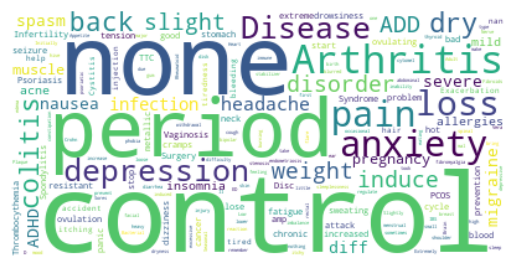

In [11]:
# Mild ADRs:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

temp = df.query('label<0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

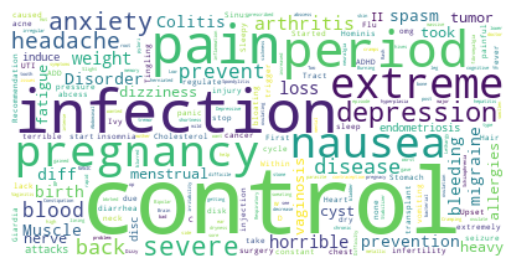

In [12]:
# Severe ADRs:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

temp = df.query('label>0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### spaCy

In [13]:
!pip install --user spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.1 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.2.3 requires scikit-plot, which is not installed.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
explainerdashboard 0.4.8 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.0 which is incompatible.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.

In [14]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import spacy
from spacy import displacy

text = df.text.iloc[0]
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.render(doc, style="ent")

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu
pipe("""The patient reported no recurrence of palpitations at follow-up 6 months after the ablation.""")

Device set to use cpu


[{'entity_group': 'Sign_symptom',
  'score': 0.9999311,
  'word': 'pal',
  'start': 38,
  'end': 41},
 {'entity_group': 'Sign_symptom',
  'score': 0.90633154,
  'word': '##pitations',
  'start': 41,
  'end': 50},
 {'entity_group': 'Clinical_event',
  'score': 0.99975544,
  'word': 'follow',
  'start': 54,
  'end': 60},
 {'entity_group': 'Date',
  'score': 0.999867,
  'word': '6 months after',
  'start': 64,
  'end': 78}]